# PatchCore Example

#### Import dependencies

In [1]:
import anodet

import torch
import cv2
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 

## Training

#### Load dataset

In [13]:
data_path = '../../data/mvtec_dataset/bottle/train/good/'
dataset = anodet.AnodetDataset(data_path)
dataloader = DataLoader(dataset, batch_size=32, pin_memory=True)
print("Number of images in dataset:", len(dataloader.dataset))

Number of images in dataset: 209


#### Init the model

In [14]:
patch_core = anodet.PatchCore()

#### Fit the model to the dataset

In [15]:
patch_core.fit(dataloader)

Feature extraction: 100%|██████████| 7/7 [00:12<00:00,  1.78s/it]


Getting transformed features...
Calculating distances...
Maximum distance from cluster centers is 2.10


#### Save the necessary parameters

In [16]:
distributions_path = './distributions/'
torch.save(patch_core.embedding_coreset, distributions_path+'bottle_embedding_coreset.pt')

# 

## Inference
#### Load test images

In [2]:
paths = [
    '../../data/mvtec_dataset/bottle/test/broken_large/000.png',
    '../../data/mvtec_dataset/bottle/test/broken_small/000.png',
    '../../data/mvtec_dataset/bottle/test/contamination/000.png',
    '../../data/mvtec_dataset/bottle/test/good/000.png',
    '../../data/mvtec_dataset/bottle/test/good/001.png',
]

images = []
for path in paths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)
    
batch = anodet.to_batch(images, anodet.standard_image_transform, torch.device('cpu'))

#### Load the necessary parameters

In [3]:
distributions_path = './distributions/'
embedding_coreset = torch.load(distributions_path+'bottle_embedding_coreset.pt')

#### init the model

In [4]:
patch_core = anodet.PatchCore('resnet18', embedding_coreset=embedding_coreset)

#### Make prediction

In [58]:
image_scores, score_maps = patch_core.predict(batch)

#### Interpret the prediction

In [53]:
THRESH = 2.4
score_map_classifications = anodet.classification(score_maps, THRESH)
image_classifications = anodet.classification(image_scores, THRESH)
print("Image scores:", image_scores)
print("Image classifications:", image_classifications)

Image scores: tensor([3.1091, 2.4268, 2.7036, 1.6846, 1.5608])
Image classifications: tensor([0., 0., 0., 1., 1.])


#### Visualization

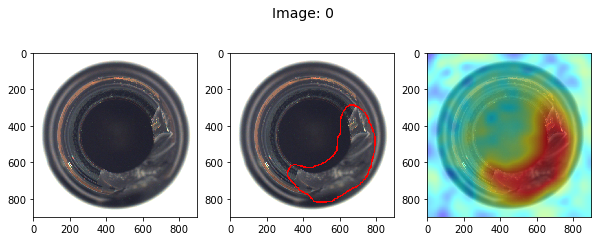

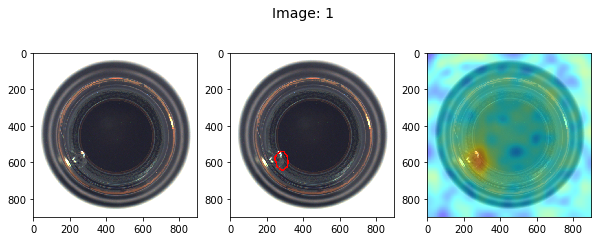

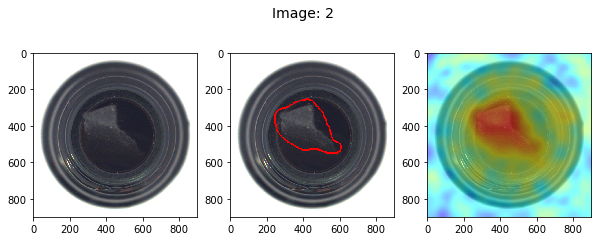

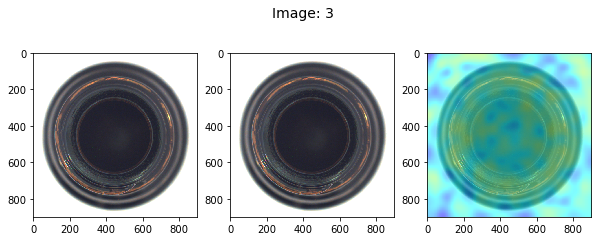

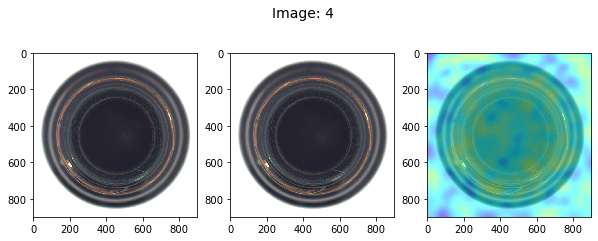

In [57]:

for idx in range(len(images)):

    b_img = anodet.boundary_image(images[idx], score_map_classifications[idx])
    h_img = anodet.heatmap_image(images[idx], score_maps[idx], (0, 3.5))

    fig, axs = plt.subplots(1, 3, figsize=(10, 6))
    fig.suptitle('Image: ' + str(idx), y=0.8, fontsize=14)
    axs[0].imshow(images[idx])
    axs[1].imshow(b_img)
    axs[2].imshow(h_img)
    plt.show()